In [1]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [2]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

# set omp threads one of two ways
num_threads = 4

# this is the general way to set it for all computations
from few.utils.utility import omp_set_num_threads
omp_set_num_threads(num_threads)

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
    num_threads=num_threads,  # 2nd way for specific classes
)

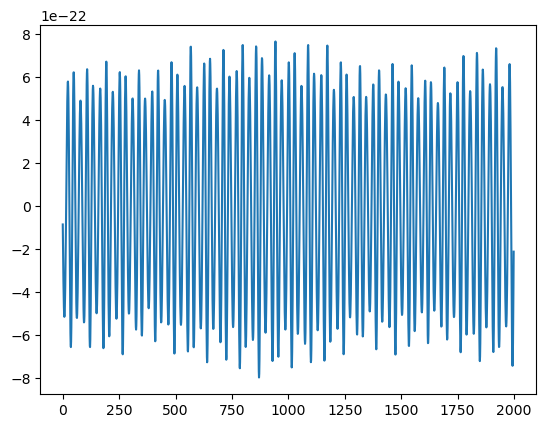

In [6]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")

# parameters
T = 4  # years
dt = 10.0  # seconds
M = 5e5
a = 0.98
mu = 50
p0 = 11.0
e0 = 0.1
x0 = 0.7  # notice this is x_I, not Y. The AAK waveform can convert to Y. 
qK = 0.2  # polar spin angle
phiK = 0.2  # azimuthal viewing angle
qS = 0.3  # polar sky angle
phiS = 0.3  # azimuthal viewing angle
dist = 1# distance
Phi_phi0 = 1.0
Phi_theta0 = 2.0
Phi_r0 = 3.0

sig = gen_wave(
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
    T=T,
    dt=dt,
)
lenth=2000
timearray=np.arange(lenth)
plt.plot(timearray,sig.real[:lenth])
plt.show
sig=np.sqrt(sig.real**2+sig.imag**2)
# temp=h[:2000]
# h=temp


In [7]:
print(len(sig))

725418


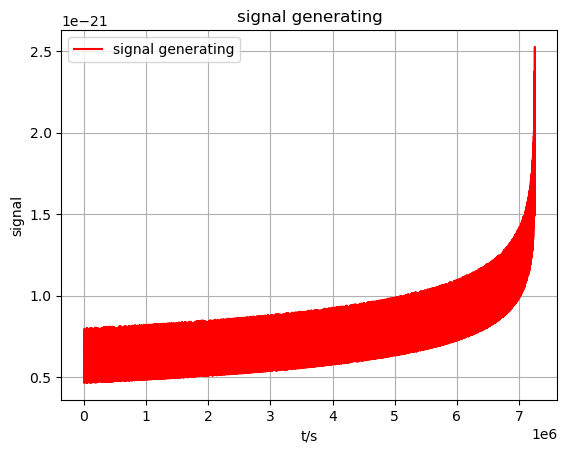

In [8]:
def signal(t,snr,coeff):
    phi=t*coeff[0]+coeff[1]*t**2+coeff[2]*t**3
    signal=np.sin(2*pi*phi)
    norm=np.sqrt(sum(signal*signal))
    return snr*signal/norm
#tmax=1
#snr=10
#coeff=np.array([10,3,6])
max_freq=0.01
nyq_freq=2*max_freq

samp_intrv=dt
samp_freq=1/dt
t=np.arange(0,len(sig)*dt,dt)
Num=len(t)
#sig=signal(t,snr,coeff)
plt.plot(t,sig,'r',label="signal generating")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("signal")
plt.legend(loc='upper left')
plt.title("signal generating")
plt.show()



-2


/home/tianyu/.julia/conda/3/envs/few_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


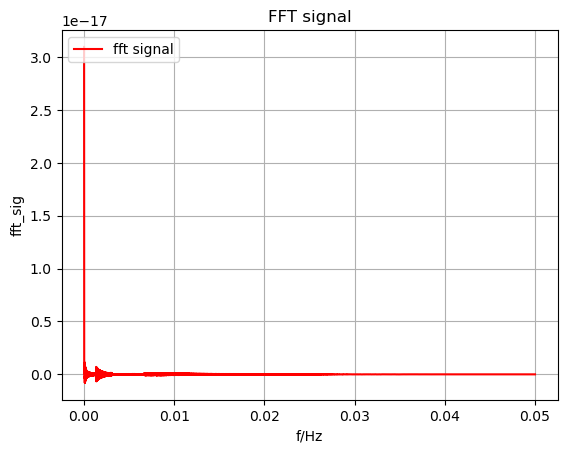

In [9]:
print(math.floor(-1.1))
data_len=t[-1]-t[0]
k_nyq=math.floor(Num/2)+1
pos_freq=np.arange(0,k_nyq-1)*(1/data_len)
fft_sig=fft(sig)
fft_sig=fft_sig[1:k_nyq]
plt.plot(pos_freq,fft_sig,'r',label="fft signal")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("fft_sig")
plt.legend(loc='upper left')
plt.title("FFT signal")
plt.show()


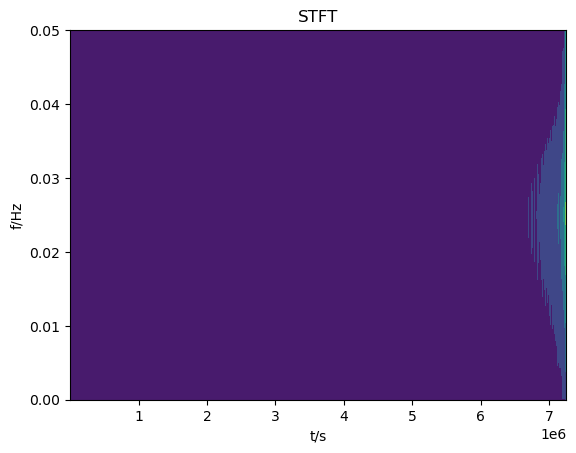

In [11]:
win_len=40#sec
ovrlp=20#sec
win_len_samp=int(np.floor(win_len*samp_freq))
ovrlp_samp=int(np.floor(ovrlp*samp_freq))
from scipy.signal import spectrogram
f,T,S=spectrogram(sig,samp_freq,'hamming',nperseg=win_len_samp,noverlap=ovrlp_samp,nfft=None)
X,Y = np.meshgrid(T,f)
plt.contourf(X,Y,S)
#plt.plot(label="STFT signal")
plt.xlabel("t/s")
plt.ylabel("f/Hz")
#plt.legend(loc='upper left')
plt.title("STFT")
plt.show()

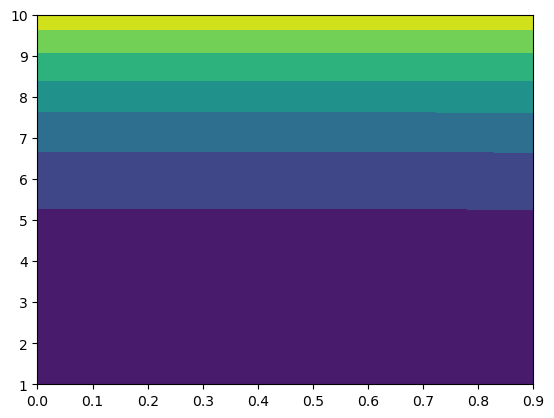

In [ ]:
#test
f=np.arange(0,1,0.1)
T=np.arange(1,11)


X,Y = np.meshgrid(f,T)
S=X**2+Y**3
plt.contourf(X,Y,S)